У цьому ноутбуці ми розберемо явище мультиколінеарності, та способи протидії мультиколінеарності.

Мультиколінеарність можна побачити по кореляційній матриці даних (багато значень >0.9 )

Розберемо типові способи протидії мультиколінеарності:

1) відкидання зайвих ознак

2) регуляризація (регресії Ridge, Lasso)

3) перехід у новий простір ознак (метод головних компонент - PCA)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [2]:
data = pd.read_csv("train.csv", index_col = 'id')
data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [3]:
categorical = ['Sex']
target = 'Age'
numerical = data.columns.difference(categorical+[target]).tolist()

numerical

['Diameter',
 'Height',
 'Length',
 'Shell Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Weight']

Outlier removal

In [4]:
for col in numerical:
    mean, std = data[col].mean(), data[col].std()
    data = data[(data[col]>=mean-3*std) & (data[col]<=mean+3*std) ]

<Axes: >

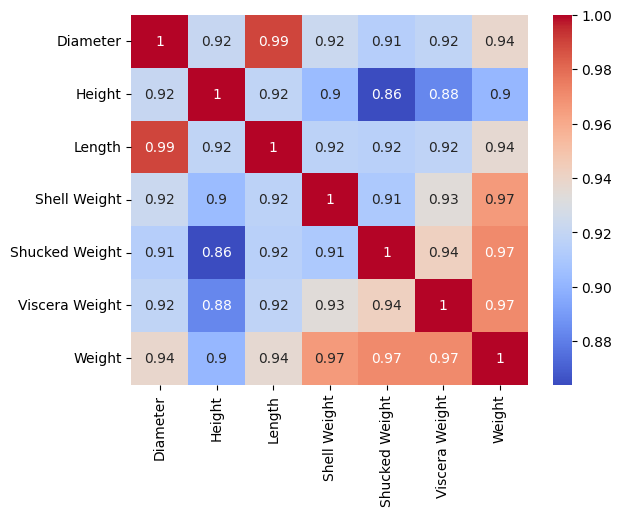

In [5]:
sns.heatmap(data[numerical].corr(), cmap = 'coolwarm', annot = True)

По матриці кореляцій можна бачити, що в даних висока мультиколінеарність (практично всі змінні корелюють одна із одною із $ r_{ij} >=0.9 $

In [6]:
data[numerical].corrwith(data[target]).sort_values(ascending=False)

Shell Weight      0.663473
Height            0.638067
Diameter          0.621256
Length            0.612843
Weight            0.601195
Viscera Weight    0.576808
Shucked Weight    0.503320
dtype: float64

### Чи впливає стандартизація на кореляцію в даних?

$$ X_{stded} = \cfrac{X - \mu}{\sigma} $$

In [7]:
## standartization
data_stded = data.copy()

for col in numerical:
    mean, std = data_stded[col].mean(), data_stded[col].std()
    data_stded[col] = (data_stded[col] - mean)/(std)

In [8]:
#спосіб зробити те саме, але через sklearn
"""
from sklearn.preprocessing import StandardScaler
std_scaler = StandartScaler()
data_stded_arr = std_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками
data_stded = pd.DataFrame(data_stded, columns = numerical) #повертаємо назви колонок

#категорійні колонки не змінюємо
for cat_col in categorical:
    data_stded[cat_col] = data[cat_col]
"""

'\nfrom sklearn.preprocessing import StandardScaler\nstd_scaler = StandartScaler()\ndata_stded_arr = std_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками\ndata_stded = pd.DataFrame(data_stded, columns = numerical) #повертаємо назви колонок\n\n#категорійні колонки не змінюємо\nfor cat_col in categorical:\n    data_stded[cat_col] = data[cat_col]\n'

### Дивимось, чи змінилася матриця кореляції при стандартизації даних

In [9]:
(data[numerical].corr() - data_stded[numerical].corr()).round(5)

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight
Diameter,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
Height,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
Length,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
Shell Weight,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
Shucked Weight,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
Viscera Weight,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
Weight,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0


### Чи змінюється кореляція даних при mix-max нормуванні?

$$ X_{normed} = \cfrac{X - X_{min}}{X_{max}-X_{min}} $$

In [10]:
## normalization
data_normed = data.copy()

for col in numerical:
    min_, max_ = data_normed[col].min(), data_normed[col].max()
    data_normed[col] = (data_normed[col] - min_)/(max_ - min_)

In [11]:
#спосіб зробити те саме, але через sklearn
"""
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
data_normed_arr = minmax_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками
data_normed = pd.DataFrame(data_normed, columns = numerical) #повертаємо назви колонок

#категорійні колонки не змінюємо
for cat_col in categorical:
    data_normed[cat_col] = data[cat_col]
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\nminmax_scaler = MinMaxScaler()\ndata_normed_arr = minmax_scaler.fit_transform(data[numerical]) #тут отримуємо np.array із нормалізованими колонками\ndata_normed = pd.DataFrame(data_normed, columns = numerical) #повертаємо назви колонок\n\n#категорійні колонки не змінюємо\nfor cat_col in categorical:\n    data_normed[cat_col] = data[cat_col]\n'

In [12]:
(data[numerical].corr() - data_normed[numerical].corr()).round(5)

,Diameter,Height,Length,Shell Weight,Shucked Weight,Viscera Weight,Weight
Diameter,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
Height,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
Length,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
Shell Weight,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
Shucked Weight,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
Viscera Weight,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
Weight,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0


Надалі в цьому ноутбуці, будемо вважати що ми вже привели дані до одної шкали і будемо в основному користуватись data_stded.

Побудуємо типову модель лінійної регресії на всіх змінних, щоб далі нам було від чого відштовхуватись